In [1]:
import matplotlib.pyplot as mpl
import scipy.cluster.hierarchy as sch,random,numpy as np,pandas as pd
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt


In [2]:
def getIVP(cov,**kargs):
    # Compute the inverse-variance portfolio
    ivp=1./np.diag(cov)
    ivp/=ivp.sum()
    return ivp


def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters

        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = pd.concat([sortIx, df0]).sort_index()  # concatenate instead of append
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

def getRecBipart(cov,sortIx):
    # Compute HRP alloc
    w=pd.Series(1,index=sortIx, dtype=float)
    cItems=[sortIx] # initialize all items in one cluster
    while len(cItems)>0:
        cItems=[elem[j:k] for elem in cItems for j,k in \
                ((0,len(elem)//2), (len(elem)//2,len(elem))) if len(elem)>1] # bi-section
        # print("humus", len(cItems), cItems)
        for i in range(0,len(cItems),2): # parse in pairs
            cItems0=cItems[i] # cluster 1
            cItems1=cItems[i+1] # cluster 2
            cVar0=getClusterVar(cov,cItems0)
            cVar1=getClusterVar(cov,cItems1)
            alpha=1-cVar0/(cVar0+cVar1)
            w[cItems0]*=alpha # weight 1
            w[cItems1]*=1-alpha # weight 2
    return w

def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist=((1-corr)/2.)**.5 # distance matrix
    return dist


def plotCorrMatrix(path,corr,labels=None):
    # Heatmap of the correlation matrix
    if labels is None:labels=[]
    mpl.pcolor(corr)
    mpl.colorbar()
    mpl.yticks(np.arange(.5,corr.shape[0]+.5),labels)
    mpl.xticks(np.arange(.5,corr.shape[0]+.5),labels)
    mpl.savefig(path)
    mpl.clf();mpl.close() # reset pylab
    return


def generateData(nObs,size0,size1,sigma1):
    # Time series of correlated variables
    #1) generating some uncorrelated data
    np.random.seed(seed=12345);random.seed(12345)
    x=np.random.normal(0,1,size=(nObs,size0)) # each row is a variable
    #2) creating correlation between the variables
    cols=[random.randint(0,size0-1) for i in range(size1)]
    y=x[:,cols]+np.random.normal(0,sigma1,size=(nObs,len(cols)))
    x=np.append(x,y,axis=1)
    x=pd.DataFrame(x,columns=range(1,x.shape[1]+1))
    print(x.shape)
    return x,cols



In [3]:
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform

# --- Core HRP building blocks ---
def correlDist(corr):
    return ((1 - corr) / 2.0) ** 0.5

def getIVP(cov):
    ivp = 1. / np.diag(cov)
    return ivp / ivp.sum()

def getClusterVar(cov, items):
    cov_ = cov.loc[items, items]
    w_ = getIVP(cov_).reshape(-1, 1)
    return (w_.T @ cov_.values @ w_)[0, 0]

def getQuasiDiag(link):
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)
        df0 = sortIx[sortIx >= numItems]
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = pd.concat([sortIx, df0]).sort_index()
        sortIx.index = range(sortIx.shape[0])
    return sortIx.tolist()

def getRecBipart(cov, sortIx):
    w = pd.Series(1.0, index=sortIx)
    cItems = [sortIx]
    while len(cItems) > 0:
        cItems = [elem[j:k] for elem in cItems for j, k in ((0, len(elem) // 2), (len(elem) // 2, len(elem))) if len(elem) > 1]
        for i in range(0, len(cItems), 2):
            cItems0 = cItems[i]
            cItems1 = cItems[i + 1]
            var0 = getClusterVar(cov, cItems0)
            var1 = getClusterVar(cov, cItems1)
            alpha = 1 - var0 / (var0 + var1)
            w[cItems0] *= alpha
            w[cItems1] *= 1 - alpha
    return w

# --- Block HRP: apply HRP within blocks and across blocks ---
def block_hrp(data, asset_to_group):
    groups = sorted(set(asset_to_group.values()))
    asset_groups = {g: [a for a in data.columns if asset_to_group[a] == g] for g in groups}
    cov = data.cov()
    corr = data.corr()
    
    # Step 1: HRP within each group
    intra_weights = {}
    for group, assets in asset_groups.items():
        sub_cov = cov.loc[assets, assets]
        sub_corr = corr.loc[assets, assets]
        dist = correlDist(sub_corr)
        link = sch.linkage(squareform(dist), method='single')
        sortIx = getQuasiDiag(link)
        sorted_assets = sub_corr.index[sortIx].tolist()
        intra_weights[group] = getRecBipart(sub_cov, sorted_assets)

    # Step 2: Build meta-asset covariance (groups)
    group_returns = pd.DataFrame(index=data.index)
    for g, weights in intra_weights.items():
        group_returns[g] = data[weights.index].dot(weights)
    group_cov = group_returns.cov()
    group_corr = group_returns.corr()
    
    dist = correlDist(group_corr)
    link = sch.linkage(squareform(dist), method='single')
    sortIx = getQuasiDiag(link)
    sorted_groups = group_corr.index[sortIx].tolist()
    inter_weights = getRecBipart(group_cov, sorted_groups)

    # Step 3: Combine intra-group and inter-group weights
    final_weights = pd.Series(0.0, index=data.columns)
    for g in groups:
        final_weights[intra_weights[g].index] = intra_weights[g] * inter_weights[g]
    
    return final_weights.sort_values(ascending=False)

In [4]:
def main():
    #1) Generate correlated data
    nObs,size0,size1,sigma1=250,5,5,25
    x,cols=generateData(nObs,size0,size1,sigma1) # x is of size 10000 by 10 (250 by 14?)
    print([(j+1,size0+i) for i,j in enumerate(cols,1)])
    #2) compute and plot correl matrix
    cov,corr=x.cov(),x.corr()
    plotCorrMatrix('HRP3_corr0.png',corr,labels=corr.columns)
    # 3) cluster


    dist=correlDist(corr)
    condensed_dist_matrix = squareform(dist)
    link=sch.linkage(condensed_dist_matrix,'single')
    
    fig = plt.figure(figsize=(25, 10))
    dn = sch.dendrogram(link)
    plt.show()


    sortIx=getQuasiDiag(link)
    sortIx=corr.index[sortIx].tolist() # recover labels
    df0=corr.loc[sortIx,sortIx] # reorder
    plotCorrMatrix('HRP3_corr1.png',df0,labels=df0.columns)
    #4) Capital allocation
    hrp=getRecBipart(cov,sortIx)
    print(hrp)
    # return

(250, 10)
[(4, 6), (1, 7), (3, 8), (3, 9), (2, 10)]


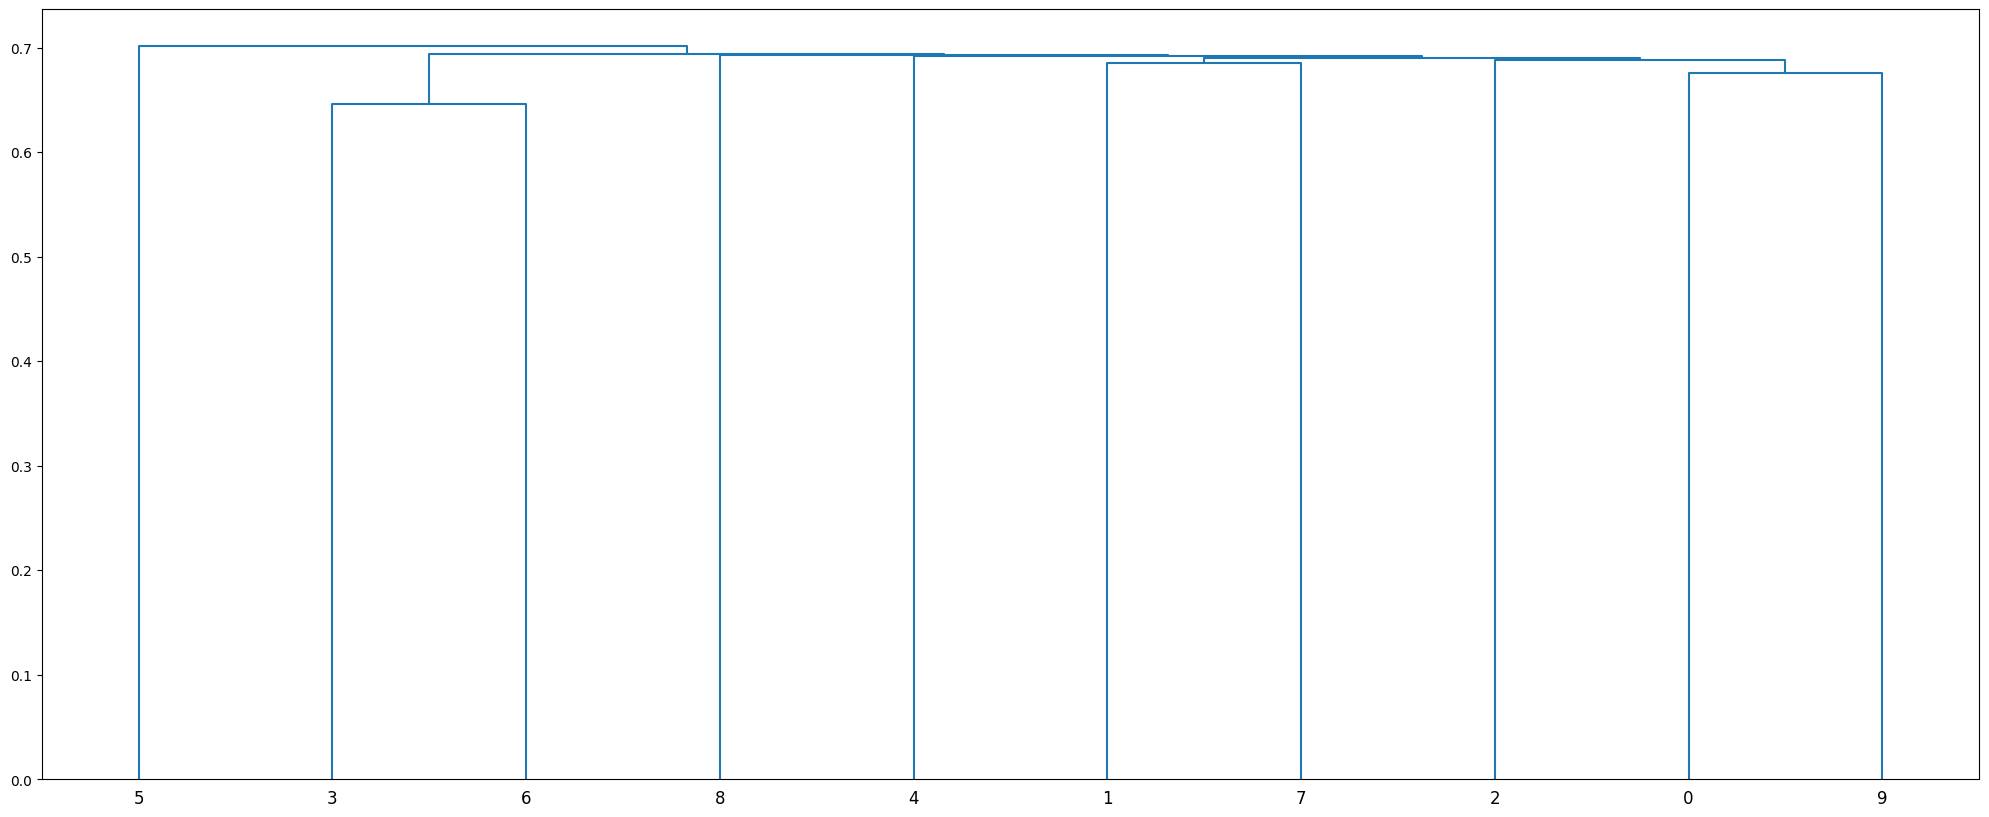

6     0.000260
4     0.165999
7     0.000275
9     0.000273
5     0.225800
2     0.167214
8     0.000251
3     0.215073
1     0.224530
10    0.000323
dtype: float64


In [5]:
main()

## Load real data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kendalltau
from sklearn.decomposition import PCA
from numpy.linalg import eigvalsh, cond
from scipy.stats import kendalltau

# For matrix cleaning
from scipy.linalg import eigh

# Set plotting style
sns.set(style='whitegrid')


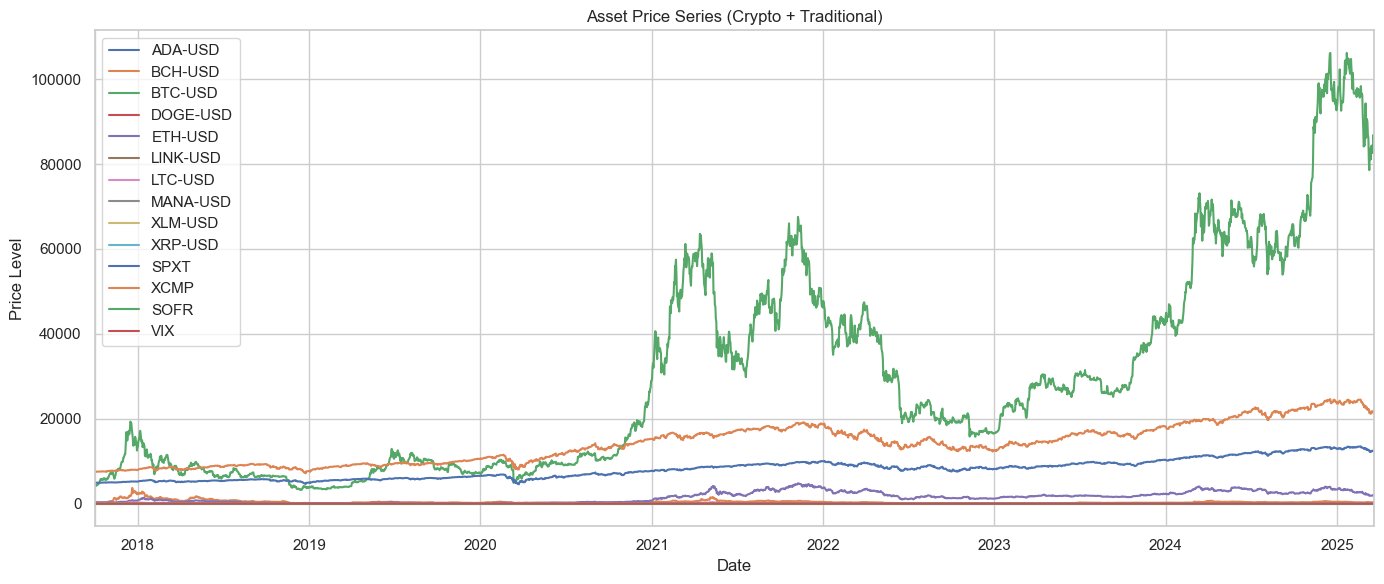

In [5]:
# Set plot style
sns.set(style='whitegrid')

# Load the dataset
data = pd.read_csv('./fin413_data.csv', sep=';')

# Convert 'Date' to datetime and set as index
# Convert 'Date' to datetime and set as index
data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y')
data.set_index('Date', inplace=True)

# Define correct asset names
crypto_names = [
    'ADA-USD', 'BCH-USD', 'BTC-USD', 'DOGE-USD', 'ETH-USD',
    'LINK-USD', 'LTC-USD', 'MANA-USD', 'XLM-USD', 'XRP-USD'
]
traditional_names = ['SPXT', 'XCMP', 'SOFR', 'VIX']
all_assets = crypto_names + traditional_names


# Forward-fill missing values and drop remaining nulls
prices = data[all_assets].ffill().dropna()

# Confirm cleaned shape

# Plot the cleaned price series
prices.plot(figsize=(14, 6), title="Asset Price Series (Crypto + Traditional)")
plt.ylabel("Price Level")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
# # Define key dates
# datePP = '2021-09-11'
# dateTr = '2022-11-21'

# # Compute log returns

# # weekdays_only = prices[prices.index.weekday < 5]
# # weekdays_only = prices

# # log_returns = np.log(weekdays_only / weekdays_only.shift(1)).dropna()
# log_returns = np.log(prices / prices.shift(1)).dropna()

# # Window size based on Lopez de Prado (2016)
# window_size = 250

# # Ensure the dates exist in the index
# assert pd.to_datetime(datePP) in log_returns.index
# assert pd.to_datetime(dateTr) in log_returns.index

# # Extract sample windows
# window_pp = log_returns.loc[:datePP].iloc[-window_size:]
# # window_pp = log_returns
# window_tr = log_returns.loc[:dateTr].iloc[-window_size:]

# # Compute sample covariance matrices
# cov_pp = window_pp.cov()
# cov_tr = window_tr.cov()
# # cov_pp = window_pp.corr()
# # cov_tr = window_tr.corr()


# # Print basic info
# print("Covariance matrix at datePP (11-Sep-2021):")
# display(cov_pp)

# print("Covariance matrix at dateTr (21-Nov-2022):")
# display(cov_tr)

import numpy as np
import pandas as pd

def shuffle_covariance_matrix(cov_matrix, cols_to_shuffle):
    """
    Shuffle selected columns and rows in a covariance matrix to check order-independence.
    
    Args:
        cov_matrix (pd.DataFrame): Symmetric covariance matrix.
        cols_to_shuffle (list): List of column labels (not indices) to shuffle.
        
    Returns:
        pd.DataFrame: A new covariance matrix with selected rows/columns shuffled.
    """

    # Create a copy of the matrix
    cov = cov_matrix.copy()
    cols_to_shuffle = [cov.columns[i] for i in cols_to_shuffle]

    # Determine new shuffled order for the selected columns
    shuffled = np.random.permutation(cols_to_shuffle)

    # Create new column order
    all_cols = list(cov.columns)
    col_order = [col for col in all_cols if col not in cols_to_shuffle]
    for i, col in enumerate(shuffled):
        col_order.insert(all_cols.index(cols_to_shuffle[i]), col)

    # Reindex both rows and columns
    return cov.loc[col_order, col_order]

In [16]:
datePP = '2021-09-11'
dateTr = '2022-11-21'

print(prices.shape)

weekdays_only = prices[prices.index.weekday < 5]

# print(weekdays_only.shape)

# log_returns = np.log(prices / prices.shift(1)).dropna()
log_returns = np.log(weekdays_only / weekdays_only.shift(1)).dropna()
print(log_returns.shape)

window_size = 250


# # Extract sample windows
window_pp = log_returns.loc[:datePP].iloc[-window_size:]
# # window_pp = log_returns
window_tr = log_returns.loc[:dateTr].iloc[-window_size:]

# Extract sample windows
# window_pp = weekdays_only.loc[:datePP].iloc[-window_size:]
# window_pp = log_returns
# window_tr = weekdays/_only.loc[:dateTr].iloc[-window_size:]

print(window_pp.shape)
print(window_tr.shape)

# np.log(prices) - np.log(prices.shift(1))
# np.log(prices/prices.shift(1)).dropna()

(2728, 14)
(1948, 14)
(250, 14)
(250, 14)


In [73]:
# def clean_covariance_matrix(cov_matrix, clip_threshold=1e-4):
#     # Eigen decomposition
#     eigvals, eigvecs = np.linalg.eigh(cov_matrix)
    
#     # Clip small eigenvalues
#     eigvals[eigvals < clip_threshold] = clip_threshold
    
#     # Reconstruct the cleaned covariance matrix
#     cleaned_cov_matrix = eigvecs @ np.diag(eigvals) @ eigvecs.T
#     return cleaned_cov_matrix, eigvals, eigvecs

def clean_covariance_matrix(cov_matrix: pd.DataFrame, clip_threshold=1e-4):
    # Eigen decomposition (values and vectors as NumPy arrays)
    eigvals, eigvecs = np.linalg.eigh(cov_matrix.values)

    # Clip small eigenvalues
    eigvals = np.clip(eigvals, clip_threshold, None)

    # Reconstruct the cleaned covariance matrix
    cleaned_matrix = eigvecs @ np.diag(eigvals) @ eigvecs.T

    # Return as a DataFrame with original index/columns
    cleaned_df = pd.DataFrame(cleaned_matrix, index=cov_matrix.index, columns=cov_matrix.columns)

    return cleaned_df

def build_hrp(data):
    #2) compute and plot correl matrix
    cov,corr=data.cov(),data.corr()

    cov = clean_covariance_matrix(cov)

    # cov = shuffle_covariance_matrix(cov, cols_to_shuffle=[3, 4, 5, 7, 11, 12])
    # corr = shuffle_covariance_matrix(corr, cols_to_shuffle=[3, 4, 5, 7, 11, 12])
    # print(cov, corr)
    plotCorrMatrix('HRP3_corr0.png',corr,labels=corr.columns)
    # 3) cluster

    dist=correlDist(corr)

    # does it break anything? only changes predictions a bit
    condensed_dist_matrix = squareform(dist)
    link=sch.linkage(condensed_dist_matrix,'single')
    # link=sch.linkage(dist,'single')
    
    fig = plt.figure(figsize=(25, 10))
    dn = sch.dendrogram(link)
    plt.show()
    
    sortIx=getQuasiDiag(link)
    sortIx=corr.index[sortIx].tolist() # recover labels
    df0=corr.loc[sortIx,sortIx] # reorder
    plotCorrMatrix('HRP3_corr1.png',df0,labels=df0.columns)
    #4) Capital allocation
    hrp=getRecBipart(cov,sortIx)

    # w = hrp.clip(lower=1e-3)  # floor
    # w /= w.sum()
    # print(w)
    print(hrp)

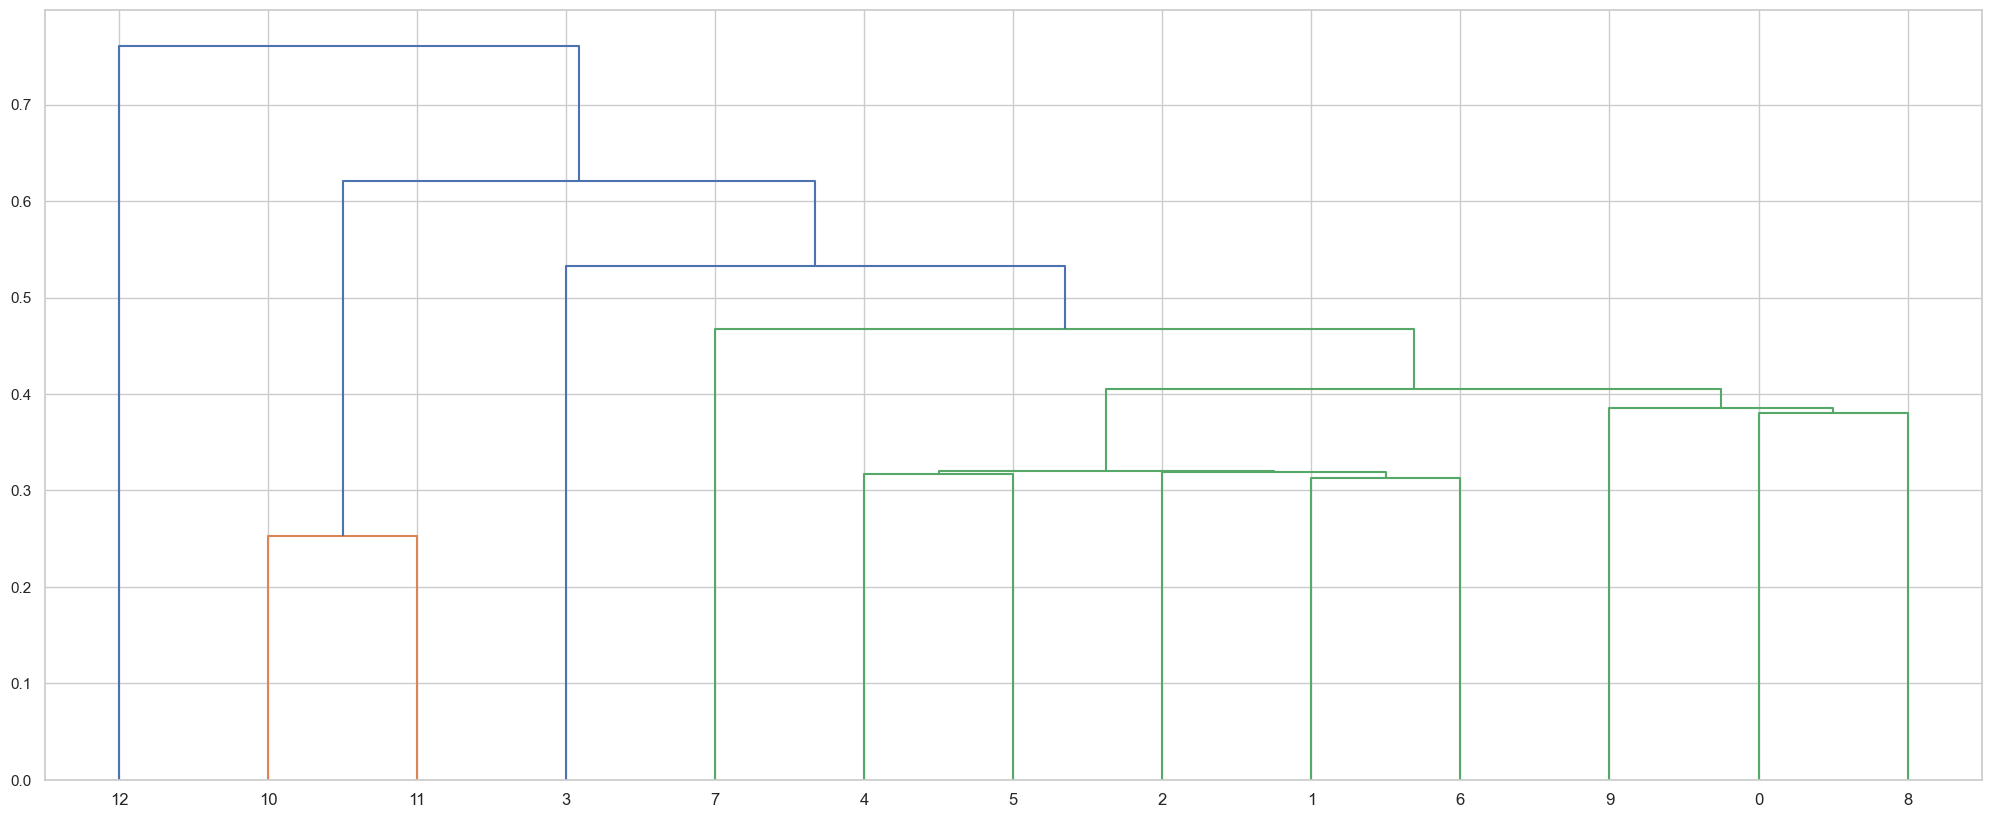

VIX         0.015852
SPXT        0.505450
XCMP        0.436389
DOGE-USD    0.002778
MANA-USD    0.004922
ETH-USD     0.009754
LINK-USD    0.004630
BTC-USD     0.007792
BCH-USD     0.003105
LTC-USD     0.003406
XRP-USD     0.001661
ADA-USD     0.002385
XLM-USD     0.001877
dtype: float64


In [76]:
# excluded = ['SOFR', 'XCMP', 'SPXT', 'VIX']
excluded = ['SOFR']
# excluded = []
df_filtered = window_pp.drop(columns=excluded)

build_hrp(df_filtered)
# build_hrp(window_pp)
# asset_to_group = {
#     # Group 1: Cryptos (first 10)
#     'ADA-USD': 'Crypto',
#     'BCH-USD': 'Crypto',
#     'LINK-USD': 'Crypto',
#     'XLM-USD': 'Crypto',
#     'DOGE-USD': 'Crypto',
#     'XRP-USD': 'Crypto',
#     'ETH-USD': 'Crypto',
#     'LTC-USD': 'Crypto',
#     'BTC-USD': 'Crypto',
#     'MANA-USD': 'Crypto',

#     # Group 2: Macro/TradFi (last 4)
#     'XCMP': 'Macro',
#     'SPXT': 'Macro',
#     'SOFR': 'Macro',
#     'VIX': 'Macro',
# }

# # Subset your DataFrame if needed
# data_subset = window_pp[list(asset_to_group.keys())]
# weights = block_hrp(data_subset, asset_to_group)

# print(weights)


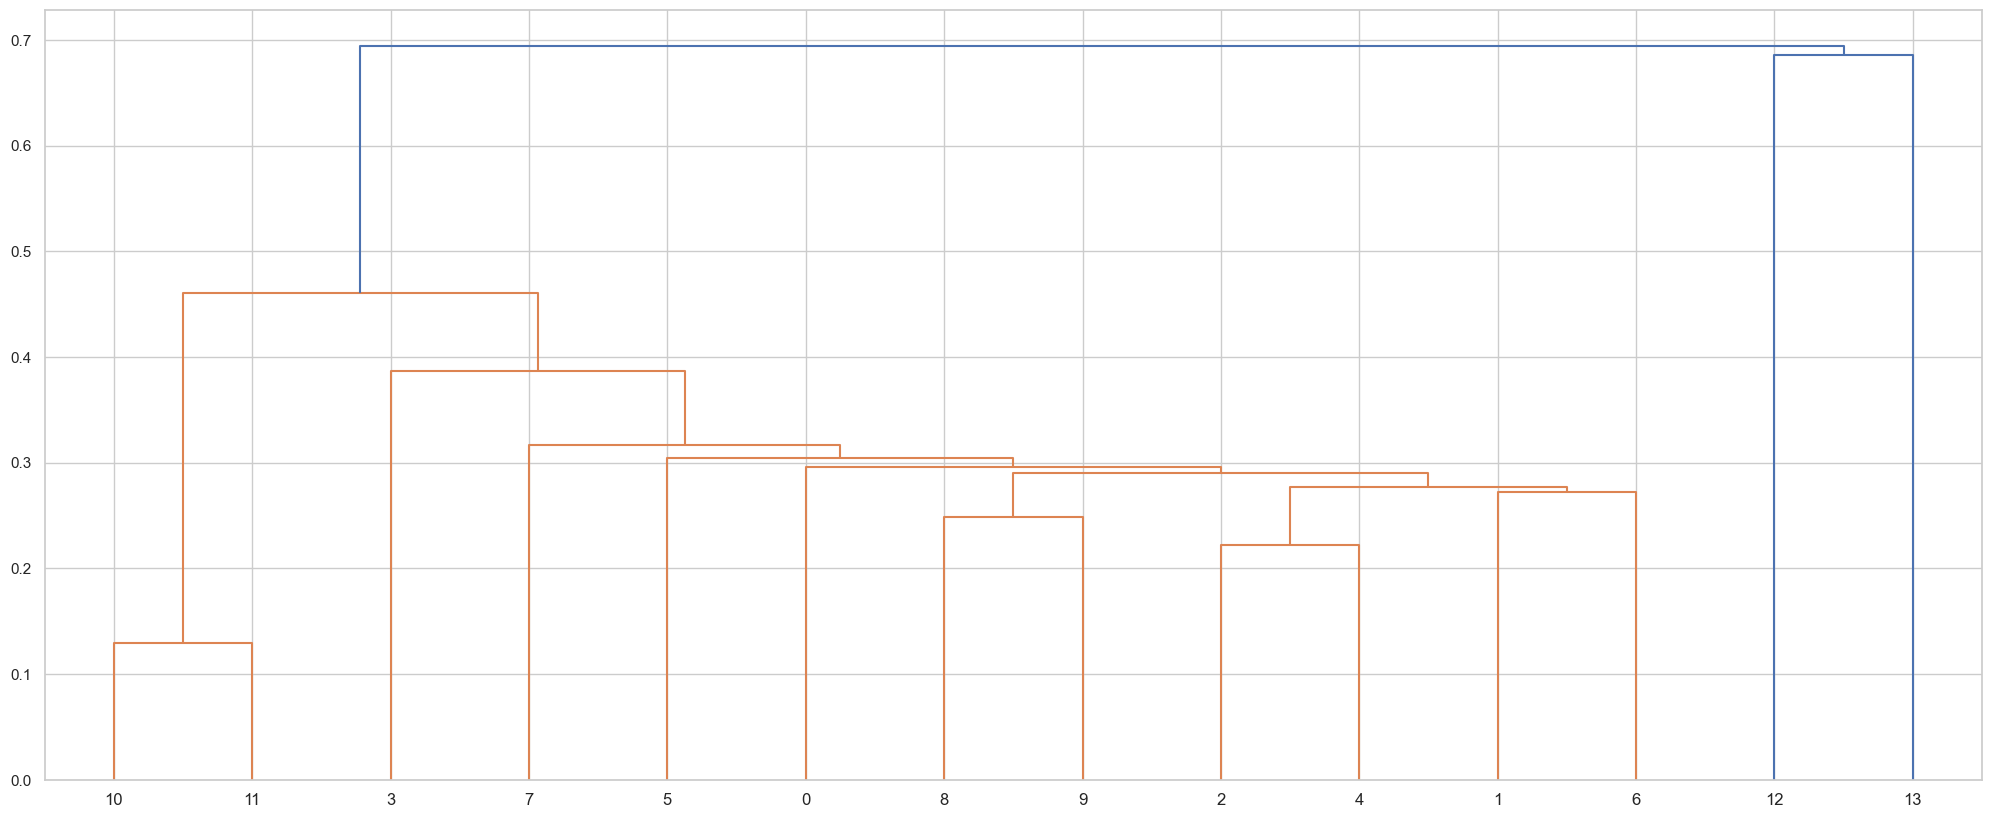

SPXT        6.758505e-06
XCMP        3.142002e-06
DOGE-USD    2.711102e-07
MANA-USD    1.794388e-07
LINK-USD    2.015767e-07
ADA-USD     2.357448e-07
XLM-USD     3.260921e-07
XRP-USD     8.605938e-07
BTC-USD     7.921686e-07
ETH-USD     4.391614e-07
BCH-USD     7.751103e-07
LTC-USD     8.077749e-07
SOFR        9.999843e-01
VIX         9.372607e-07
dtype: float64


In [13]:
build_hrp(window_tr)

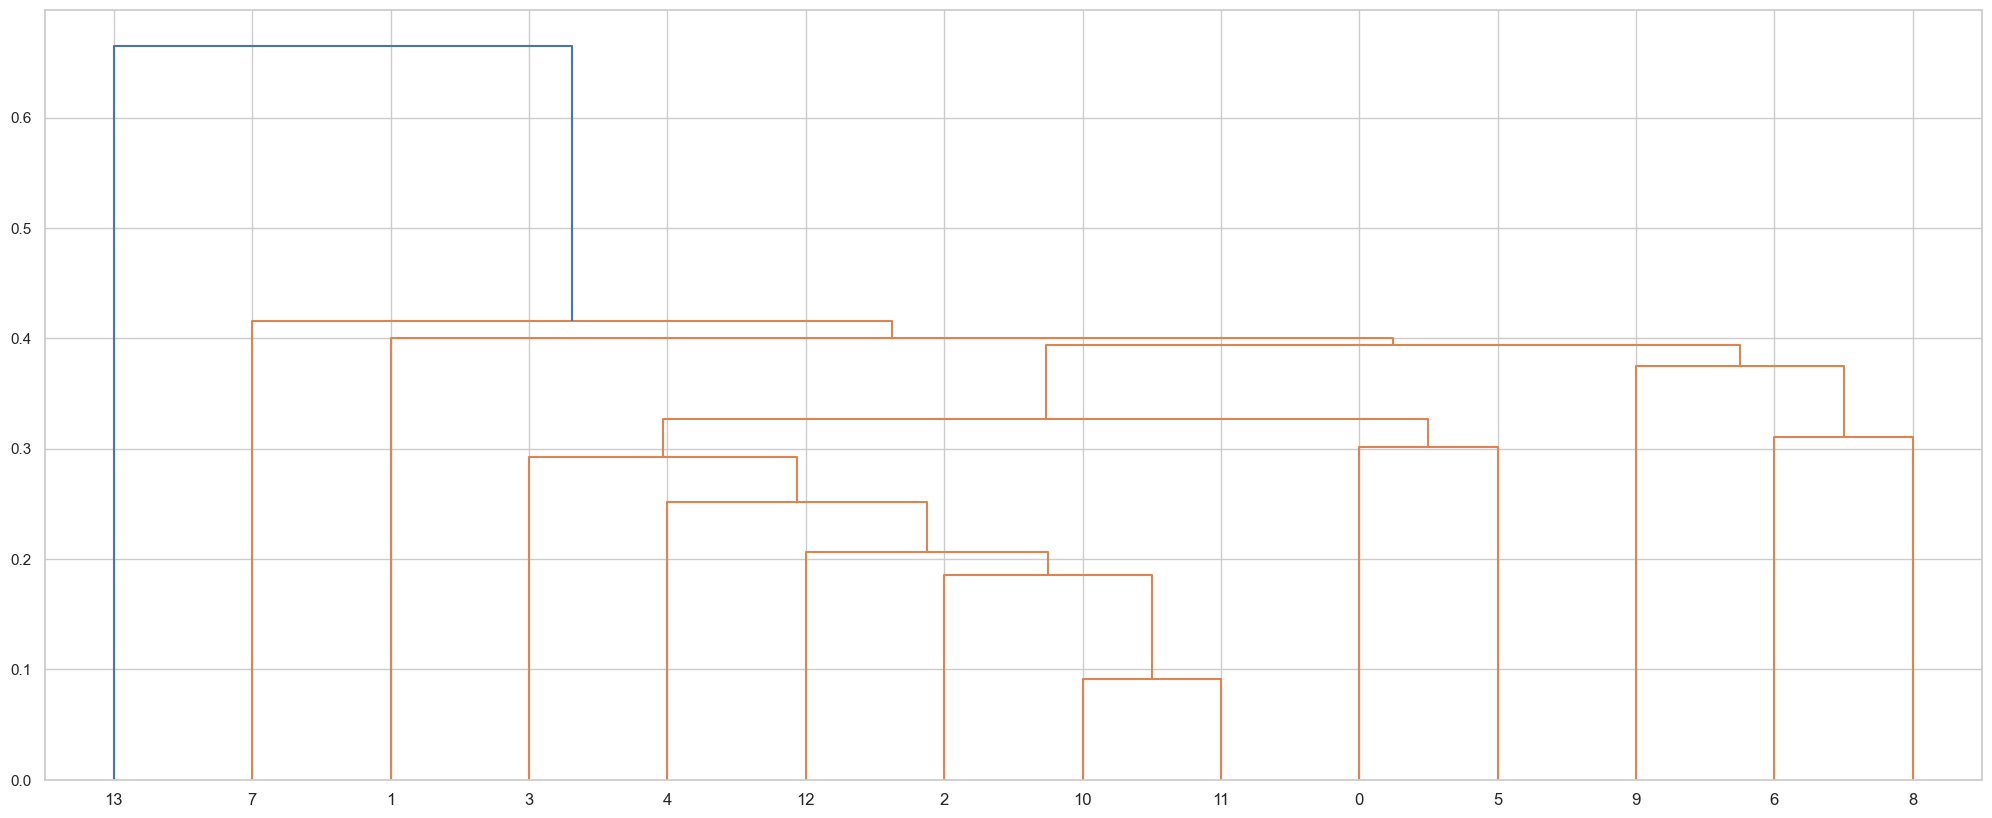

VIX         0.000992
MANA-USD    0.004362
BCH-USD     0.000992
DOGE-USD    0.165352
ETH-USD     0.000992
SOFR        0.722691
BTC-USD     0.000992
SPXT        0.000992
XCMP        0.000992
ADA-USD     0.006880
LINK-USD    0.000992
XRP-USD     0.005512
LTC-USD     0.000992
XLM-USD     0.087266
dtype: float64


In [53]:
build_hrp(prices)

                  AAPL        AVGO         BKNG        COST       CSCO  \
Date                                                                     
2024-05-13  185.656021  132.135620  3713.978271  771.162903  47.260689   
2024-05-14  186.802155  136.336273  3741.597656  773.898804  47.522816   
2024-05-15  189.084518  141.882462  3761.114502  782.991760  48.221828   
2024-05-16  189.204102  139.507492  3704.071045  788.990723  46.930607   
2024-05-17  189.233994  137.843842  3677.632080  791.716675  46.765556   

                  META        NFLX       NVDA       PYPL        TSLA  
Date                                                                  
2024-05-13  466.308868  616.590027  90.369308  63.950001  171.889999  
2024-05-14  470.134918  613.659973  91.325996  64.580002  177.550003  
2024-05-15  479.789673  613.520020  94.598907  63.900002  173.990005  
2024-05-16  471.509857  610.520020  94.328003  64.099998  174.839996  
2024-05-17  470.194672  621.099976  92.448608  64.48000

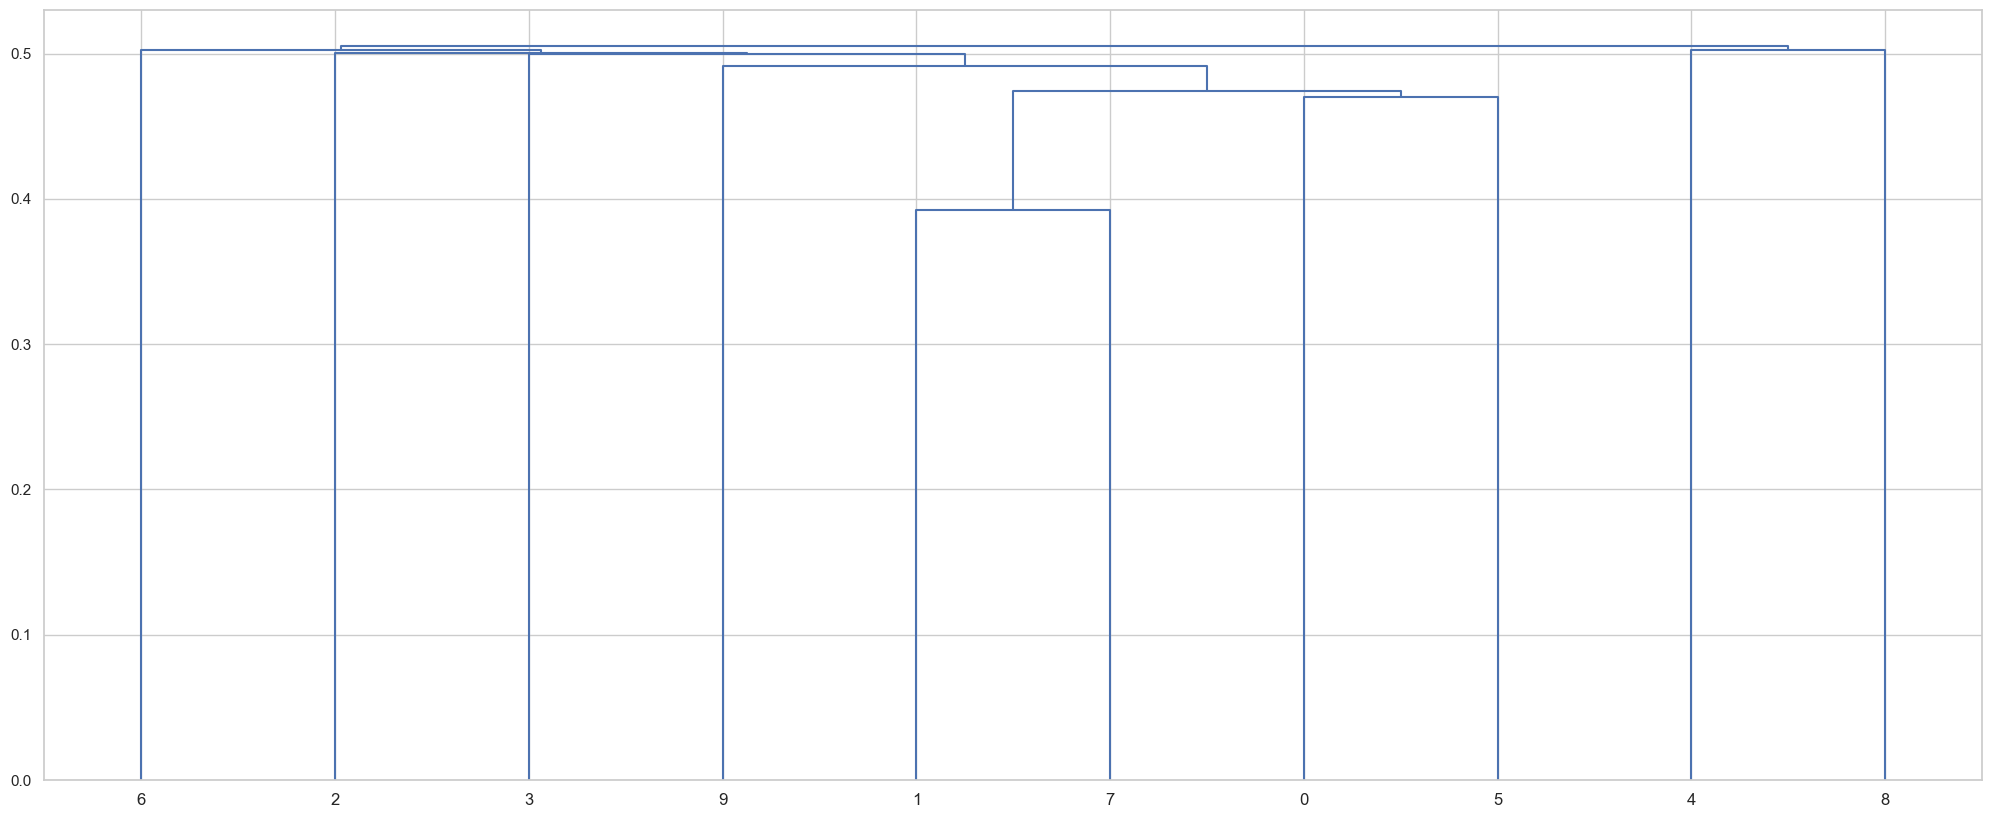

NFLX    0.109015
BKNG    0.131831
COST    0.253256
TSLA    0.015900
AVGO    0.020940
NVDA    0.035789
AAPL    0.120778
META    0.090859
CSCO    0.162298
PYPL    0.059333
dtype: float64


In [14]:
top10_data = pd.read_csv("top10_nasdaq_prices.csv", index_col=0, parse_dates=True)
print(top10_data.head())

top10_returns = np.log(top10_data / top10_data.shift(1)).dropna()

print(top10_returns.shape)
top10_returns.head()

build_hrp(top10_returns)

In [82]:
# # --- Schweizer–Wolff δ₁ dependence distance ---
# def d1_schweizer_wolff(copula_func, grid_size=20):
#     u_vals = np.linspace(0, 1, grid_size)
#     v_vals = np.linspace(0, 1, grid_size)
#     integral = 0.0
#     for u in u_vals:
#         for v in v_vals:
#             integral += np.abs(copula_func(u, v) - u * v)
#     return 12 * integral / (grid_size ** 2)

# def compute_pairwise_dependence_distance(df, method="d1", grid_size=20):
#     n = df.shape[1]
#     dist_matrix = np.zeros((n, n))
#     for i in range(n):
#         for j in range(i + 1, n):
#             x = df.iloc[:, i].rank(pct=True).values
#             y = df.iloc[:, j].rank(pct=True).values
#             def empirical_C(u, v):
#                 return np.mean((x <= u) & (y <= v))
#             if method == "d1":
#                 dist = d1_schweizer_wolff(empirical_C, grid_size)
#             else:
#                 raise NotImplementedError("Only d1 is implemented.")
#             dist_matrix[i, j] = dist_matrix[j, i] = dist
#     return pd.DataFrame(dist_matrix, index=df.columns, columns=df.columns)

# # --- HRP with custom distance matrix ---
# def custom_hrp(data, dist_matrix):
#     cov = data.cov()
#     condensed_dist_matrix = squareform(dist_matrix.values)
#     link = sch.linkage(condensed_dist_matrix, method='single')
    
#     fig = plt.figure(figsize=(25, 10))
#     dn = sch.dendrogram(link)
#     plt.show()
    
#     sortIx = getQuasiDiag(link)
#     sortIx = dist_matrix.index[sortIx].tolist()
#     return getRecBipart(cov, sortIx).sort_values(ascending=False)

# # --- Final wrapper ---
# def build_hrp_with_dependence_distance(df, grid_size=20):
#     dist_matrix = compute_pairwise_dependence_distance(df, method="d1", grid_size=grid_size)
#     return custom_hrp(df, dist_matrix)

from scipy.stats import norm, multivariate_normal

# def gaussian_copula_factory(x, y):
#     """Returns a Gaussian copula C(u, v) function built from rank-transformed data x and y."""
#     # Estimate Pearson correlation coefficient (on normal scores)
#     norm_x = norm.ppf(x)
#     norm_y = norm.ppf(y)
#     rho = np.corrcoef(norm_x, norm_y)[0, 1]

#     def C(u, v):
#         # Compute bivariate normal CDF with estimated rho
#         mean = [0, 0]
#         cov = [[1, rho], [rho, 1]]
#         lower = [-np.inf, -np.inf]
#         upper = [norm.ppf(u), norm.ppf(v)]
#         return multivariate_normal.cdf(upper, mean=mean, cov=cov)

#     return C

def gaussian_copula_factory(x, y):
    norm_x = norm.ppf(x)
    norm_y = norm.ppf(y)
    rho = np.corrcoef(norm_x, norm_y)[0, 1]

    def C(u, v):
        u = np.clip(u, 1e-10, 1 - 1e-10)
        v = np.clip(v, 1e-10, 1 - 1e-10)
        mean = [0, 0]
        cov = [[1, rho], [rho, 1]]
        upper = [norm.ppf(u), norm.ppf(v)]
        return multivariate_normal.cdf(upper, mean=mean, cov=cov)

    return C

from scipy.stats import kendalltau

def gumbel_copula_factory(x, y):
    """Returns a Gumbel copula C(u, v) from ranked inputs x and y."""
    # Estimate Kendall's tau
    tau, _ = kendalltau(x, y)

    # Invert tau = 1 - 1/β  ⇒  β = 1 / (1 - τ)
    beta = 1 / (1 - tau) if tau < 1 else 20  # cap β if tau ~ 1

    def C(u, v):
        if u in [0, 1] or v in [0, 1]:
            # Avoid log(0)
            u = np.clip(u, 1e-10, 1 - 1e-10)
            v = np.clip(v, 1e-10, 1 - 1e-10)
        logu = -np.log(u)
        logv = -np.log(v)
        return np.exp(-((logu**(1/beta) + logv**(1/beta))**beta))

    return C

def d1_schweizer_wolff(copula_func, grid_size=20):
    u_vals = np.linspace(0, 1, grid_size)
    v_vals = np.linspace(0, 1, grid_size)
    integral = 0.0
    for u in u_vals:
        for v in v_vals:
            integral += abs(copula_func(u, v) - u * v)
    return 12 * integral / (grid_size ** 2)

def d2_schweizer_wolff(copula_func, grid_size=20):
    u_vals = np.linspace(0, 1, grid_size)
    v_vals = np.linspace(0, 1, grid_size)
    integral = 0.0
    for u in u_vals:
        for v in v_vals:
            diff = copula_func(u, v) - u * v
            integral += diff ** 2
    return np.sqrt(90 * integral / (grid_size ** 2))

def d3_schweizer_wolff(copula_func, grid_size=100):
    u_vals = np.linspace(0, 1, grid_size)
    v_vals = np.linspace(0, 1, grid_size)
    max_diff = 0.0
    for u in u_vals:
        for v in v_vals:
            diff = abs(copula_func(u, v) - u * v)
            if diff > max_diff:
                max_diff = diff
    return 4 * max_diff

def compute_dependence_distance_matrix(df, method="d1", grid_size=20):
    n = df.shape[1]
    cols = df.columns
    mat = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            x = df.iloc[:, i].rank(pct=True).values
            y = df.iloc[:, j].rank(pct=True).values

            def C(u, v):
                return np.mean((x <= u) & (y <= v))
            # C = gaussian_copula_factory(x, y)
            # C = gumbel_copula_factory(x, y)

            if method == "d1":
                d = d1_schweizer_wolff(C, grid_size)
            elif method == "d2":
                d = d2_schweizer_wolff(C, grid_size)
            elif method == "d3":
                d = d3_schweizer_wolff(C, grid_size)
            else:
                raise ValueError("Unknown method: choose 'd1', 'd2', or 'd3'")

            mat[i, j] = mat[j, i] = d

    return pd.DataFrame(mat, index=cols, columns=cols)


# def hrp_schweizer_wolff(df, method="d1", grid_size=20):
#     cov = df.cov()
#     dist_matrix = compute_dependence_distance_matrix(df, method=method, grid_size=grid_size)
#     condensed = squareform(dist_matrix.values)
#     link = sch.linkage(condensed, method="single")
#     sortIx = getQuasiDiag(link)
#     sorted_labels = dist_matrix.index[sortIx].tolist()
#     return getRecBipart(cov, sorted_labels).sort_values(ascending=False)

# --- HRP with custom distance matrix ---
def custom_hrp(data, dist_matrix):
    cov = data.cov()
    cov = clean_covariance_matrix(cov)

    condensed_dist_matrix = squareform(dist_matrix)
    link = sch.linkage(condensed_dist_matrix, method='single')
    
    fig = plt.figure(figsize=(25, 10))
    dn = sch.dendrogram(link)
    plt.show()
    
    sortIx = getQuasiDiag(link)
    sortIx = dist_matrix.index[sortIx].tolist()
    return getRecBipart(cov, sortIx).sort_values(ascending=False)

# --- Final wrapper ---
def build_hrp_with_dependence_distance(df, grid_size=20):
    dist_matrix = compute_dependence_distance_matrix(df, method="d2", grid_size=grid_size)
    return custom_hrp(df, dist_matrix)

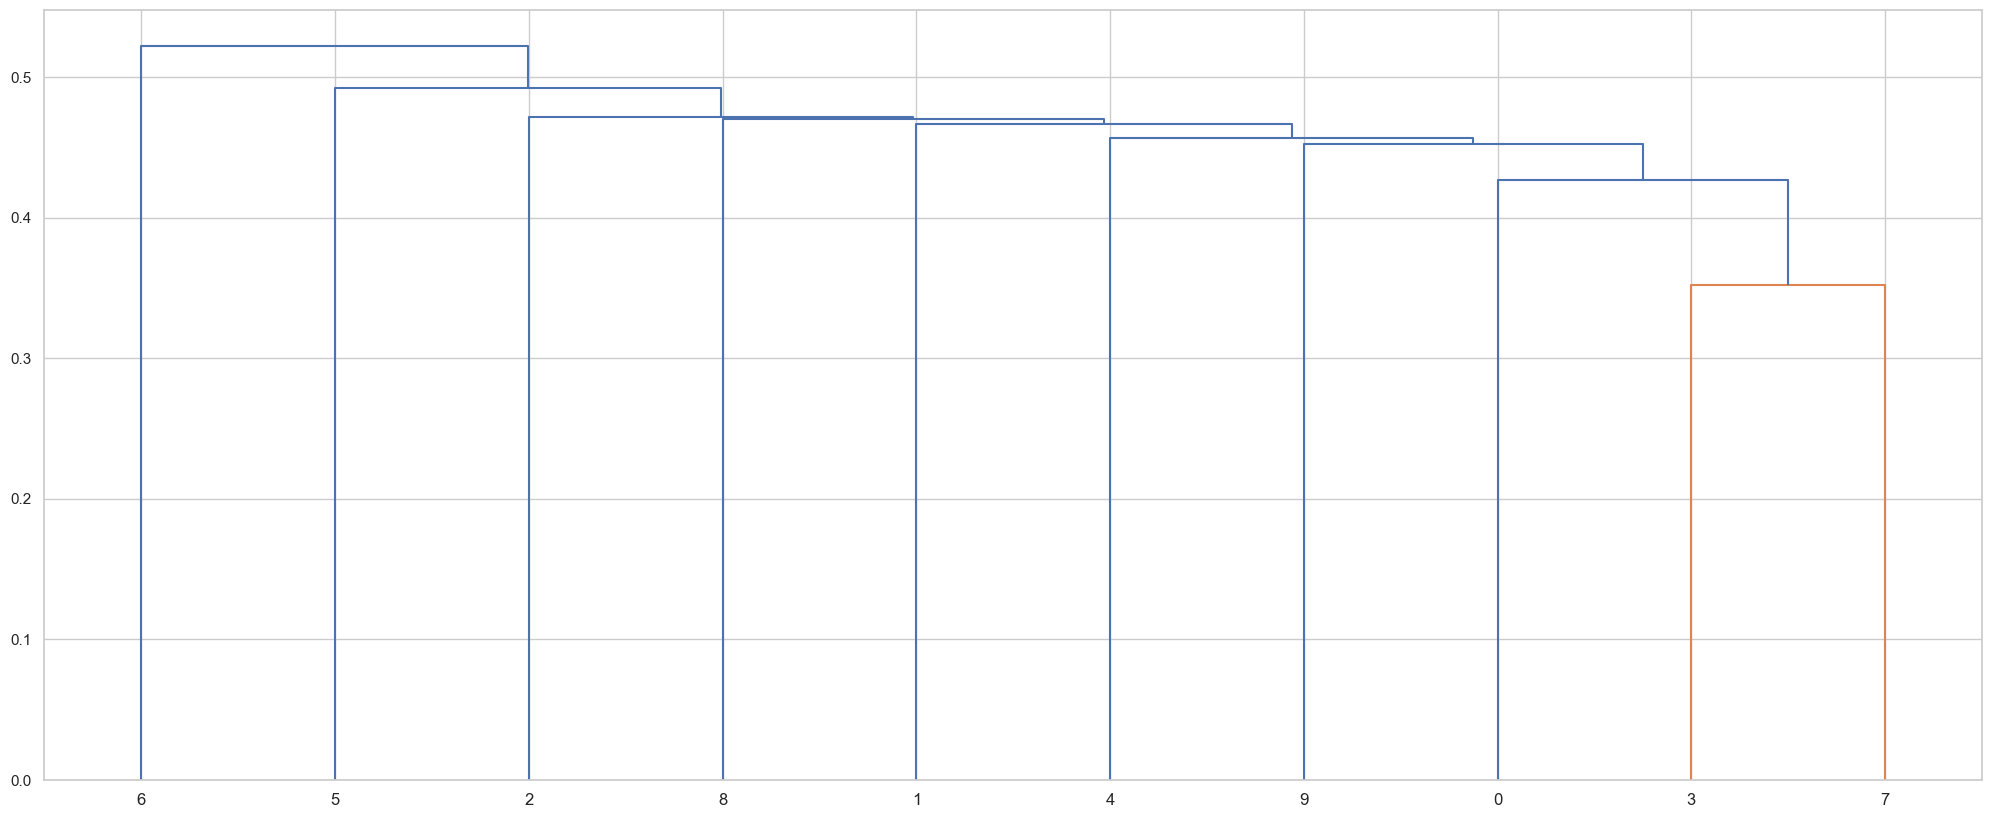

BTC-USD     0.252012
ETH-USD     0.166061
LTC-USD     0.117471
ADA-USD     0.108851
LINK-USD    0.093949
XRP-USD     0.072259
MANA-USD    0.062853
BCH-USD     0.060412
XLM-USD     0.042760
DOGE-USD    0.023372
dtype: float64


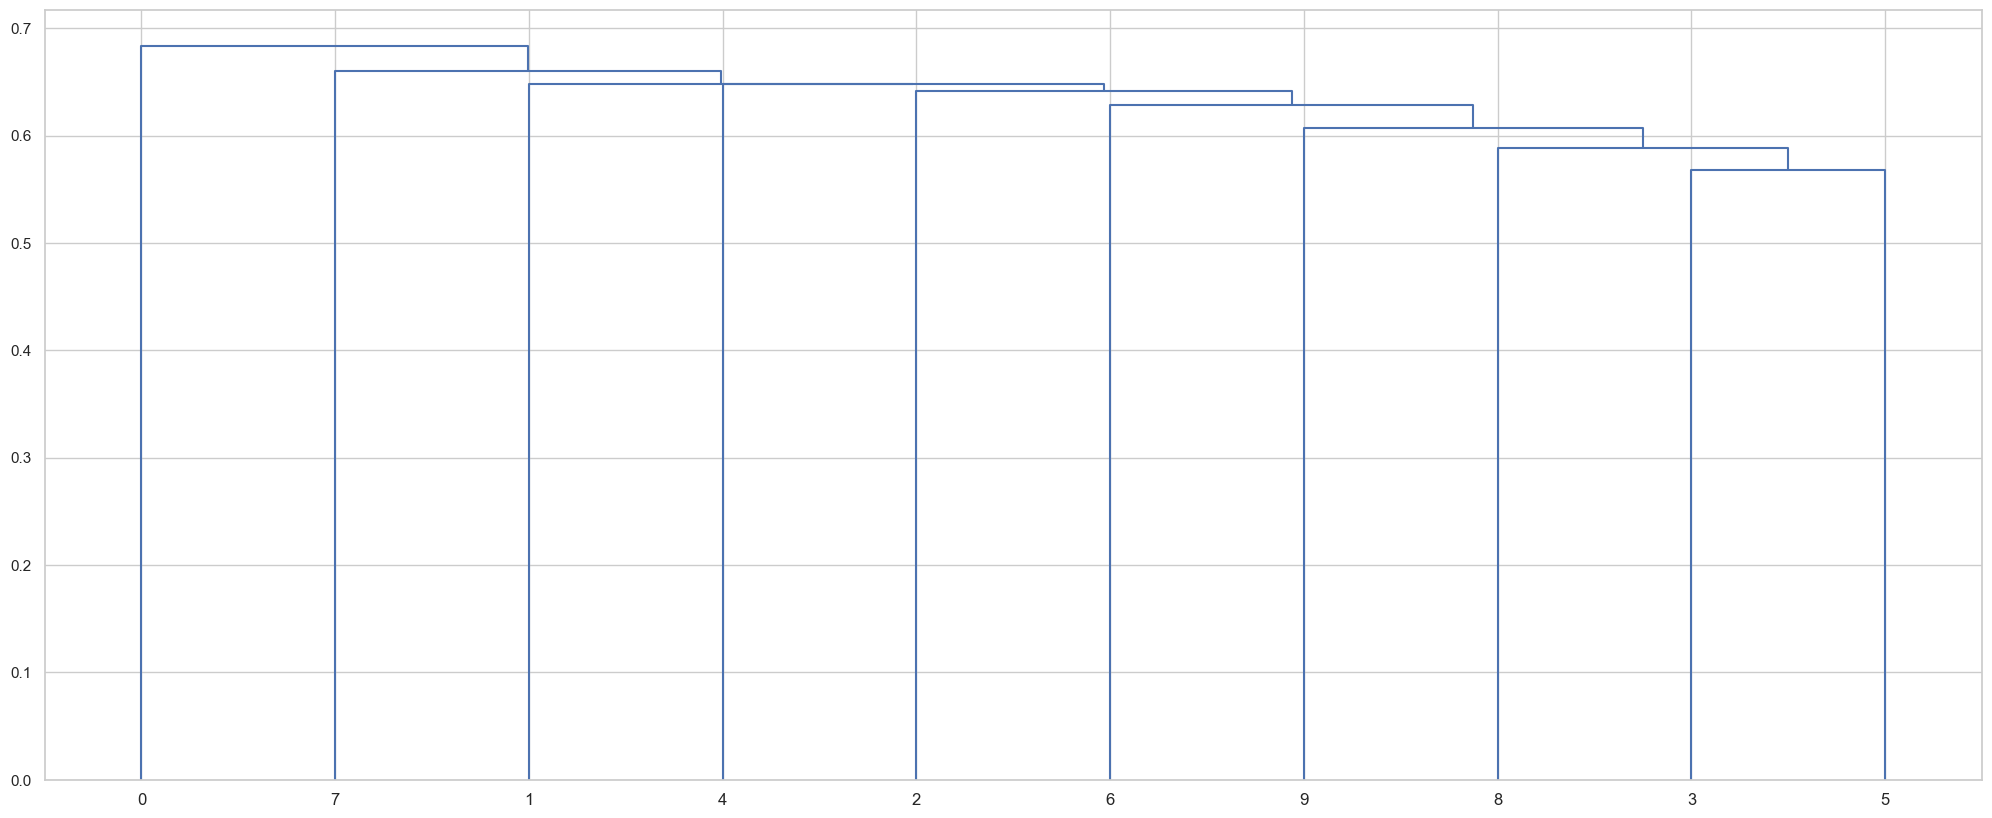

BCH-USD     0.134667
XLM-USD     0.132319
BTC-USD     0.127106
LTC-USD     0.124828
XRP-USD     0.122820
ADA-USD     0.111220
MANA-USD    0.081556
ETH-USD     0.070465
LINK-USD    0.048014
DOGE-USD    0.047005
dtype: float64


In [84]:
excluded = ['SOFR', 'XCMP', 'SPXT', 'VIX']
# excluded = []

df_filtered = window_pp.drop(columns=excluded)

# normalized_df = df_filtered.copy()
# normalized_df = normalized_df / normalized_df.std()

# Step 2: Run HRP on normalized data
weights = build_hrp_with_dependence_distance(df_filtered)
print(weights)

# # Step 3: Rescale weights using original volatility
# vol = df_filtered.std()
# weights_rescaled = weights_normalized / vol
# weights_rescaled /= weights_rescaled.sum() 

# print(weights_rescaled)

# excluded = ['SOFR', 'XCMP', 'SPXT', 'VIX']
df_filtered = window_tr.drop(columns=excluded)

weights = build_hrp_with_dependence_distance(df_filtered)
print(weights)

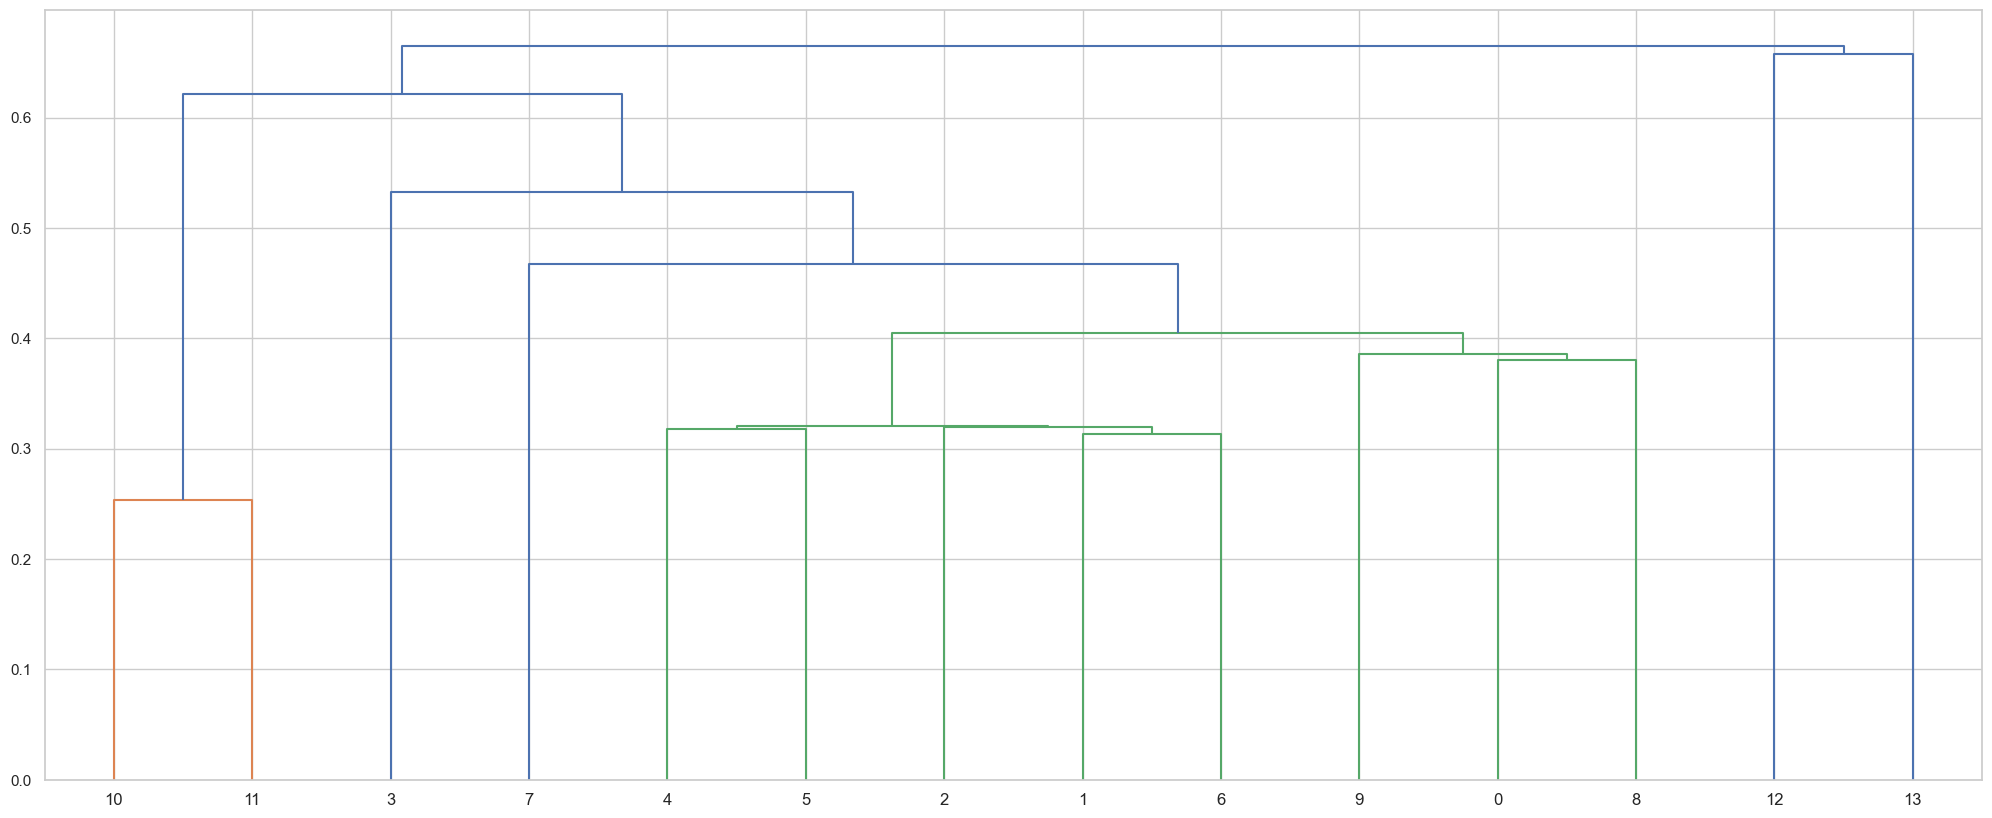

SPXT        0.089677
XCMP        0.083803
DOGE-USD    0.083803
MANA-USD    0.051664
ETH-USD     0.051664
LINK-USD    0.047349
BTC-USD     0.047349
BCH-USD     0.070571
LTC-USD     0.045207
XRP-USD     0.045207
ADA-USD     0.076500
XLM-USD     0.076500
SOFR        0.115353
VIX         0.115353
dtype: float64


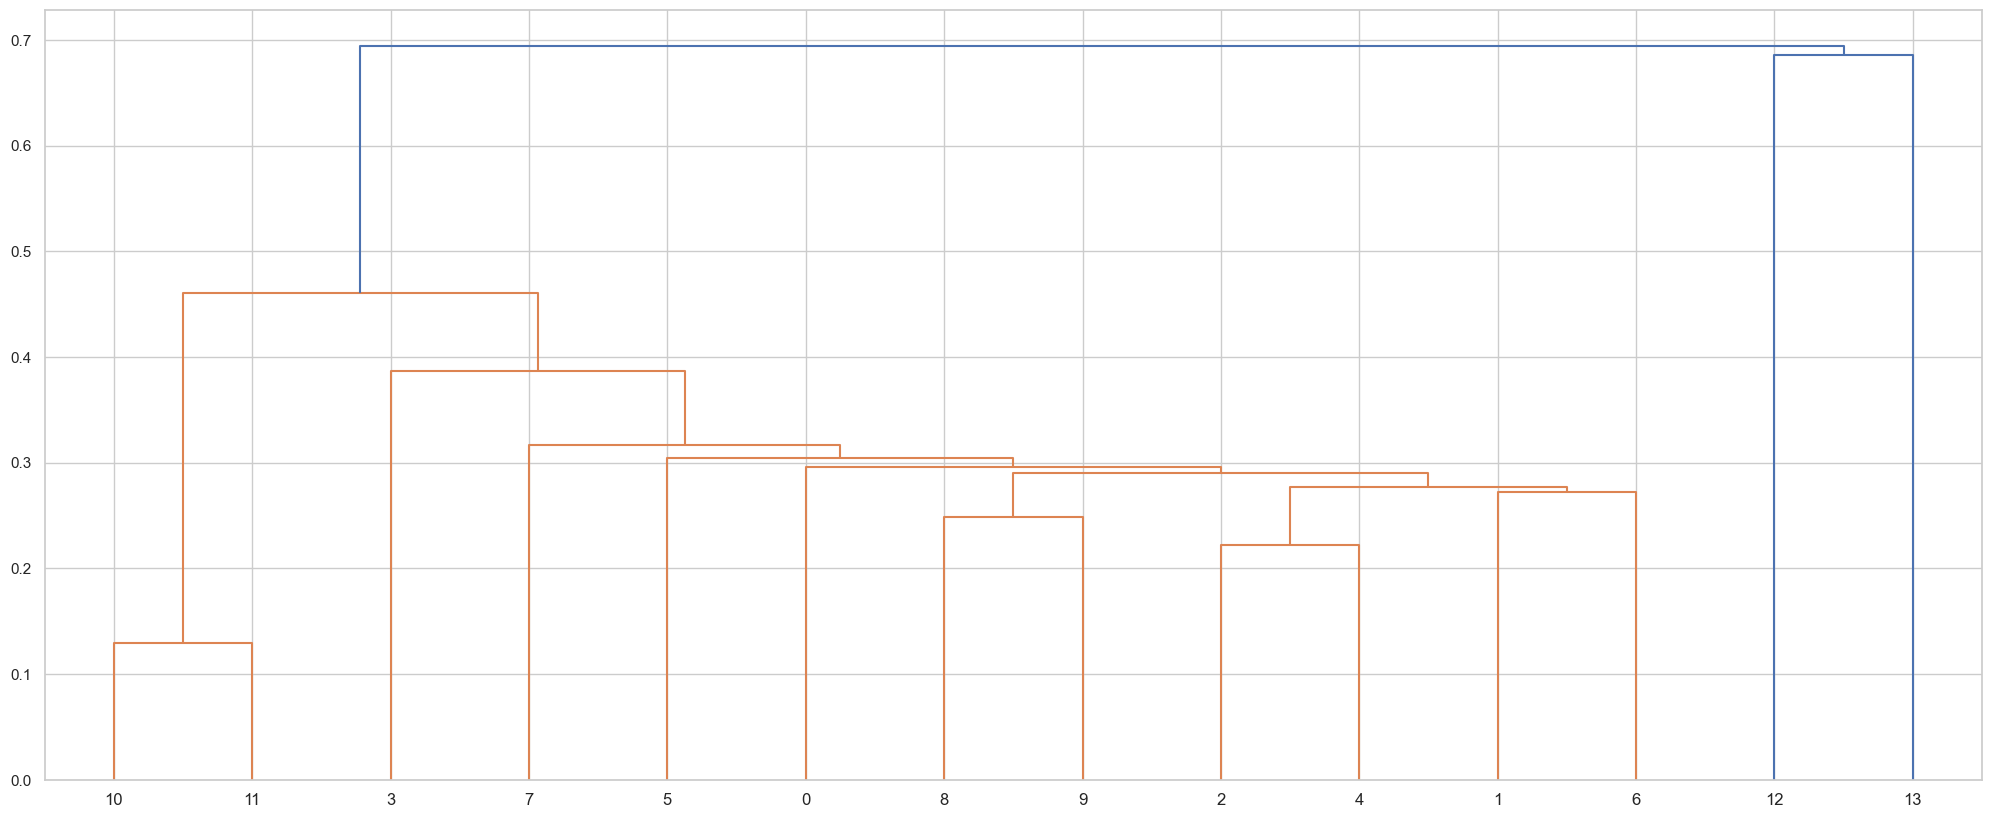

SPXT        0.000987
XCMP        0.000987
DOGE-USD    0.000987
MANA-USD    0.000987
LINK-USD    0.000987
ADA-USD     0.000987
XLM-USD     0.000987
XRP-USD     0.000987
BTC-USD     0.000987
ETH-USD     0.000987
BCH-USD     0.000987
LTC-USD     0.000987
SOFR        0.987167
VIX         0.000987
dtype: float64


In [265]:
# excluded = [col for col in window_pp.columns if col not in ['SOFR', 'XCMP', 'SPXT', 'VIX']]
excluded = []

df_filtered = window_pp.drop(columns=excluded)

normalized_df = df_filtered.copy()
normalized_df = normalized_df / normalized_df.std()

build_hrp(normalized_df)

# excluded = ['SOFR', 'XCMP', 'SPXT', 'VIX']

df_filtered = window_tr.drop(columns=excluded)

# normalized_df = df_filtered.copy()
# normalized_df = normalized_df / normalized_df.std()

build_hrp(df_filtered)

In [247]:
np.log(0.02588 / 0.02519)
# 0.02588 / 0.02519

0.027023379268180887